<table>
    <tr>
        <td>Course</td>
        <td>Foundation of Information</td>
    </tr>
    <tr>
        <td>Project</td>
        <td>Project 1 Part A Job Market Analysis</td>
    </tr>
    <tr>
        <td>Student</td>
        <td>Muhammad Kamran Syed</td>
    </tr>
</table>

---

#### Problem Statement:

##### Analysis of job market data to explore the open positions related to the jobs in the field of data or machine learning in a particular region

#### Objective & Assignment Description:

Collect and use job market data to explore data related positions or machine learning related positions in a particular region (e.g., US, India). Suggested websites for this assignment are: -

* Indeed
* Glassdoor
* Naukri
* Monster
  
<p> 
You will have to use appropriate keywords (for e.g., “data scientist”, “data engineer”, “ML engineer”) to extract information on the positions available on websites of your choice. While it is not compulsory to do so, you could use web scraping techniques introduced in this course to collect data from these websites. Also, note that you are not limited to the sites
mentioned above. Identity one job that you aspire to transition into and identify the skills required for the job.
</p>

<small>
<strong>Note:</strong> _Any one of the recommended websites can be used to extract data. Or you can select any job-related website of your choosing. You may select 1 keyword of your choice. Create a professional report in a word document that is 2 to 4 pages long by extracting the necessary information. Submit it in PDF format. Submissions do not need to include a code file. Please make sure to use Web scraping technique for data extraction._
</small>

---
# a. Collect Data using Web Scraping
---

##### Helping method to install packages if required

In [1]:
import subprocess
import sys

def pip_install_if_not_present(packageName, importName=None):
    """
    Install a package using pip if it's not already installed.

    :param packageName: The package name to install
    :param importName: In case import name is different than package name i.e. import bs4 from beautifulsoup4
    :retrun: True is package is already installed or correctly got installed. False otherwise
    """
    if importName is None:
        importName = packageName
    try:
        __import__(importName)
        print(f"package [{packageName}] is already installed")
        return True
    except ImportError as e:
        print(f"package [{packageName}] is not installed: [{e}]")
    
    print(f"Installing package [{packageName}] now...")
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", packageName])
        __import__(importName)
    except subprocess.CalledProcessError as e:
        print(f"Error installing package [{packageName}]: {e}")
        return False
    except ImportError:
        print(f"Package [{packageName}] could not be imported after installation.")
        return False
    print(f"package [{packageName}] is installed")
    return True

In [2]:
#Making sure all the packages are already installed.
pip_install_if_not_present(packageName='lxml')
pip_install_if_not_present(packageName='beautifulsoup4', importName='bs4')
pip_install_if_not_present(packageName='selenium')
pip_install_if_not_present(packageName='pandas')
pip_install_if_not_present(packageName='pprint')
pip_install_if_not_present(packageName='os')
pip_install_if_not_present(packageName='time')
pip_install_if_not_present(packageName='re')
pip_install_if_not_present(packageName="matplotlib.pyplot")
pip_install_if_not_present(packageName="seaborn")

package [lxml] is already installed
package [beautifulsoup4] is already installed
package [selenium] is already installed
package [pandas] is already installed
package [pprint] is already installed
package [os] is already installed
package [time] is already installed
package [re] is already installed
package [matplotlib.pyplot] is already installed
package [seaborn] is already installed


True

In [3]:
import os

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import time
from bs4 import BeautifulSoup
import pandas as pd
from pprint import pprint
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def has_more_records(soup):
    """
    This function checks if there are more records in the given soup of Naukri.com.

    :param soup: The BeautifulSoup object which contains web page source for Naukri job listing
    :return: True if there are more records, False otherwise
    """    
    # Locate the div with id 'jobs-list-header'
    jobs_list_header = soup.find('div', id='jobs-list-header')
    
    if jobs_list_header:
        # Find the span element that contains the record count
        count_span = jobs_list_header.find('span')
        
        if count_span:
            # Extract the text and split it to get the range and total records
            record_text = count_span.text.strip()  # "1 - 14 of 200"
            parts = record_text.split()  # ['1', '-', '14', 'of', '200']
            
            if len(parts) == 5:
                # Get the displayed end record number and the total records
                displayed_end = int(parts[2])
                total_records = int(parts[4])
                
                # Determine if there are more records on the next page
                return displayed_end < total_records
    
    # Return False if no next page is available
    return False

In [5]:
def scrape_naukri_jobs(location, job_title, total_pages=1, debug=False, chrome_driver_path=None):
    """
    Scrape job listings from Naukri.com for specific job titles and location using Selenium.

    :param location: Location to search in (e.g., "us" or "india")
    :param job_title: Single Job title to search for (e.g., "Data Scientist")
    :param total_pages: Number of pages to scrape, default is 1, if it's set to <= 0, the function will try to fetch all the listed jobs.
    :param debug: If set to true, function will yield extra debug info. Useful for debugging
    :param chrome_driver_path: Path to the ChromeDriver executable. If not provided, it will look for a relative path under drivers folder relative to the program path
    :return: DataFrame with job listing details or None in case of failure
    """
    jobs_data = []
    site_url = "https://www.naukri.com"
    output_dir = "naukri_responses"    
    
    if chrome_driver_path is None:
       # Set up the WebDriver (Make sure to download the correct version of ChromeDriver for your browser)
       # Look for the chrome driver in the drivers folder of the current file directory        
       chrome_driver_path = os.path.join(os.getcwd(), 'drivers', 'chromedriver.exe')                
    
    try:
        # Load the ChromeDriver for selenium as a Service,
        # This is the most reliable way to use ChromeDriver
        # The driver was downloaded from chrome and it is 
        # stored in the drivers folder under the same root
        service = Service(chrome_driver_path)
        # Create the driver instance which will be used to get our pages
        driver = webdriver.Chrome(service=service)
    except Exception as e:
        print(f"Error initializing the Chrome WebDriver: {e}")
        return None  # Return None on failure 
    
    #Normalize the searched terms in the format expected by job site
    jt = job_title.strip().replace(' ', '-')
    lc = location.strip().replace(' ','-')
    
    #for page in range(1, total_pages + 1, 1):
    page_no = 0
    while True:
        page_no += 1
        if page_no == 1:
            # Only use this url if first iteration
            url = f"{site_url}/{jt}-jobs-in-{lc}"            
        else:
            url = f"{site_url}/{jt}-jobs-in-{lc}-{page_no}"               
        
        print(f"Scraping URL [{url}] now")        

        # Get/Load the Page in Chrome Driver
        driver.get(url)
        # Allow the initiated page to load before start scraping.
        # Doing it less than X seconds will result in you getting
        # bloked by the service provider or the site itself. Plus
        # If page is not loaded fully we will no be able to parse 
        # the html content correctly.
        time.sleep(10)

        # Load the HTML content with BeautifulSoup using lxml parser
        soup = BeautifulSoup(driver.page_source, 'lxml')

        # Verify the soup object exists before parsing
        if soup is None: return None
        
        # Find all job listings div elements on the page
        jobs_div = soup.find_all('div', class_='srp-jobtuple-wrapper')        

        # Extract job-related details for each listed job on the page
        for job in jobs_div:
            try:
                a_title = job.find('a', class_='title')
                title = a_title.text.strip() if a_title else 'No job title'
                a_company = job.find('a', class_='comp-name')
                company = a_company.text.strip() if a_company else 'No company info'
                span_loc = job.find('span', class_='locWdth')
                st_job_loc = span_loc.text.strip() if span_loc else 'No location info'
                # Job location is a comma and in some cases hyphen separated multivalue string
                job_locs = [loc.strip() for loc in re.split(r'[,-]', st_job_loc)]                
                span_exp = job.find('span', class_='expwdth')
                experience = span_exp.text.strip() if span_exp else 'No experience info'
                span_sal = job.find('span', class_='sal-wrap').find('span', class_='sal').find('span')
                salary = span_sal.text.strip() if span_sal else 'No salary info'
                span_desc = job.find('span', class_='job-desc')
                desc = span_desc.text.strip() if span_desc else 'No description'
                span_date = job.find('span', class_='job-post-day')
                postDay = span_date.text.strip() if span_date else 'No posting period'
                a_rating = job.find('a', class_='rating')
                rating = 'No rating'
                if a_rating:
                    span_rating = a_rating.find('span', class_='main-2')
                    rating = span_rating.text.strip() if span_rating else 'No rating'
                
                reviews = 'No reviews'
                a_reviews = job.find('a', class_='review ver-line')
                reviews = a_reviews.text.strip().split(' ')[0].strip() if a_reviews else 'No reviews'                
                # Tags are List of values
                tags = []                
                li_tags = job.find_all('li', class_='dot-gt tag-li')
                if li_tags:
                    for t in li_tags:
                        temp = t.text.strip() if t else None
                        if temp is not None:
                            tags.append(temp)
                
                jobs_data.append({
                    'Title': title,
                    'Company': company,
                    'Company_Rating': rating,
                    'Company_Reviews': reviews,                    
                    'Location': job_locs,
                    'Salary_Range': salary,
                    'Experience': experience,
                    'Post_Day': postDay,
                    'Tags': tags,
                    'Description': desc,
                })
            except AttributeError as e:
                print(f"Error parsing job listing: {e}")
                continue
        
        # Verify if there are more pages to be scraped
        more_rcds = has_more_records(soup)
        if (total_pages > 0 and total_pages <= page_no) or (total_pages <= 0 and more_rcds == False):
            print(f'TotalPages:[{total_pages}] PageNo:[{page_no}] HasMoreRcds:[{more_rcds}]')
            print('No more records available, exiting')
            break
        else:
            print('More records available, processing')
            continue

    # Close the browser window opened by ChromeDriver
    driver.quit()

    # Convert the job data to a pandas DataFrame
    df = pd.DataFrame(jobs_data)

    return df

<p>
In order to demonstrate the scraping capability of my function I'll add code for a simple 2 to 3 page scraping here.
</p>

In [6]:
# This code will scrape Java Developer Jobs from Naukri for first 3 pages and loads in a database to demonstrate scraping.
# We will not persists this data, hence it'll be scraped every time we runs it.

# Example usage
title = "Java Developer"
loc = "India"
pcount = 3 

df_de = scrape_naukri_jobs(loc, title, pcount)
# Save the data to a CSV file, so that next time we don't have to scrape it again
if df_de is not None and len(df_de) > 0:
    print(f"Scraping completed. Data is loaded to dataframe.")
else:
    print(f"DataFrame has no record for title {title}")

pprint(df_de.info())
pprint(df_de.head(5))

Scraping URL [https://www.naukri.com/Java-Developer-jobs-in-India] now
More records available, processing
Scraping URL [https://www.naukri.com/Java-Developer-jobs-in-India-2] now
More records available, processing
Scraping URL [https://www.naukri.com/Java-Developer-jobs-in-India-3] now
TotalPages:[3] PageNo:[3] HasMoreRcds:[True]
No more records available, exiting
Scraping completed. Data is loaded to dataframe.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            60 non-null     object
 1   Company          60 non-null     object
 2   Company_Rating   60 non-null     object
 3   Company_Reviews  60 non-null     object
 4   Location         60 non-null     object
 5   Salary_Range     60 non-null     object
 6   Experience       60 non-null     object
 7   Post_Day         60 non-null     object
 8   Tags             60 non-nu

<p>
In the below code, I've scrapped the first 50 pages of all the job details for the job title Data Scientist in India, which were listed on Naukri.com and took me a significant amount of time. To avoid scraping the same info, again and again, every time the code is executed, I saved the data frame in a CSV file locally. When this code is executed, it'll check, if there is a file matching with job title and location that already exists locally, it'll load the data for the CSV file to analyze it, otherwise, scrape it. The data scraping capabilities were already demonstrated in the previous code block. The code can scrape all the pages of a Job Listing for a given Job Title and Location, to do so we can pass the num_pages argument as 0 or -1.
</p>

In [7]:
# Example usage
job_titles = ["Data Scientist"]
location = "India"
num_pages = 50  # Adjust the number of pages you want to scrape

for title in job_titles:
    df_file_name = f"naukri_{title}_{location}_jobs.csv"

    # Checks if the csv data doesn't exists than scrape it from Naukri and save in local csv file
    if not os.path.exists(df_file_name):
        df = scrape_naukri_jobs(location, title, num_pages)
        # Save the data to a CSV file, so that next time we don't have to scrape it again
        if df is not None and len(df) > 0:
            df.to_csv(df_file_name, index=False)
            print(f"Scraping completed. Data saved to {df_file_name}.")
        else:
            print(f"DataFrame has no record for title {title}")
    else: # If csv data is already available just load it.
        print(f'Loading from already saved file {df_file_name}')
        df = pd.read_csv(df_file_name)

df.info()

Loading from already saved file naukri_Data Scientist_India_jobs.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            990 non-null    object
 1   Company          990 non-null    object
 2   Company_Rating   990 non-null    object
 3   Company_Reviews  990 non-null    object
 4   Location         990 non-null    object
 5   Salary_Range     990 non-null    object
 6   Experience       990 non-null    object
 7   Post_Day         990 non-null    object
 8   Tags             990 non-null    object
 9   Description      990 non-null    object
dtypes: object(10)
memory usage: 77.5+ KB


In [8]:
df.head()

,Title,Company,Company_Rating,Company_Reviews,Location,Salary_Range,Experience,Post_Day,Tags,Description
0,Lead Data Scientist / Lead Machine learning E...,Atyeti,4.3,129,"['Hybrid', 'Pune(Kharadi)']",Not disclosed,8-12 Yrs,Just Now,"['Tensorflow', 'Machine Learning', 'Scikit-Lea...","Experience in designing ML pipelines, includin..."
1,Data Scientist / Data Analyst,.,No rating,No reviews,['Remote'],12-16 Lacs PA,3-5 Yrs,1 Day Ago,"['Data Science', 'NLP', 'Machine Learning', 'A...","Key Responsibilities:Data Analysis:Collect, cl..."
2,Data Scientist,Rlabs Enterprise Services,3.7,137,"['Hybrid', 'Hyderabad', 'Bengaluru']",Not disclosed,4-9 Yrs,Just Now,"['Machine Learning', 'Python', 'SQL', 'Data Vi...",Preferred experience in Data ModellingExperien...
3,Data Scientist - BLR/ HYD/ GGN,Genpact,3.9,27557,"['Hybrid', 'Hyderabad', 'Gurugram', 'Bengaluru']",Not disclosed,6-11 Yrs,6 Days Ago,"['Data Science', 'Predictive Modeling', 'Decis...","Furthermore, please do note that Genpact does ..."
4,Data Scientist,Johnson and Johnson Kenvue,4.3,31,['Bengaluru'],Not disclosed,4-6 Yrs,3 Days Ago,"['Supply chain', 'Computer science', 'Data ana...",Required Qualifications: . Strong knowledge an...


In [9]:
df.describe(include='all')

,Title,Company,Company_Rating,Company_Reviews,Location,Salary_Range,Experience,Post_Day,Tags,Description
count,990,990,990,990,990,990,990,990,990,990
unique,291,669,38,238,152,44,88,33,918,896
top,Data Scientist,IBM,No rating,No reviews,['Bengaluru'],Not disclosed,5-10 Yrs,30+ Days Ago,['Data Scientist'],"Undertaking data collection, preprocessing and..."
freq,458,18,269,269,297,906,79,565,9,14


---
# b. Market Data Visualization
---

##### Requirements

<p>
When there are large amounts of data available it is frequently useful to create a data visualization. Use the plotting tools introduced in the class or spreadsheet tools to create visualizations for at least any two of the data elements listed below. Use tabular format to represent any data that is not in a graphical format. Graphics can include any combination of histograms, bar charts, pie charts or other depictions. While it is not required, it might be interesting to you to create multivariate graphs such as but not limited to location and salary on the same graph.

* Titles of positions available</li>
* Locations where the roles are offered (including remote)
* Type of positions (Full-time or Part-time) (This data was not available on Job Listing page)
* Key skills required for these positions (use appropriate visualization techniques to present yourfindings)  
</p>

##### Step 1: Identify an Ideal Job
* Choosing "Data Scientist" as an ideal job title, we have good no of entries for this title in our scraped data to find out key skills required

In [10]:
df.Title.value_counts()

Title
Data Scientist                                                    458
Senior Data Scientist                                             102
Lead Data Scientist                                                32
Sr. Data Scientist                                                 12
Data Scientist: Artificial Intelligence                             9
                                                                 ... 
Data Analyst/Architect/Scientist/Engineer                           1
Data Scientist - Hyderabad                                          1
Data Scientist | ML | AI | LLM | RAG | Azure  - WFH (Contract)      1
Data Scientist - NLP/Artificial Intelligence                        1
Data Scientist 2                                                    1
Name: count, Length: 291, dtype: int64

In [11]:
ideal_job = 'Data Scientist'
ideal_job_titles = df[df.Title.str.contains(ideal_job, case=False, na=False)]
print(type(ideal_job_titles))
ideal_job_titles.Title.value_counts()

<class 'pandas.core.frame.DataFrame'>


Title
Data Scientist                                                    458
Senior Data Scientist                                             102
Lead Data Scientist                                                32
Sr. Data Scientist                                                 12
Data Scientist: Artificial Intelligence                             9
                                                                 ... 
Specialist, Data Scientist                                          1
Hiring Data Scientist - Pune                                        1
Data Scientist - Hyderabad                                          1
Data Scientist | ML | AI | LLM | RAG | Azure  - WFH (Contract)      1
Data Scientist 2                                                    1
Name: count, Length: 288, dtype: int64

In [36]:
# Function to normalize and combine titles
def normalize_titles(title):
    if re.match(r'^(lead|lead/|/lead|manager)', title, re.IGNORECASE):
        return "Lead Data Scientist"
    elif re.match(r'^(sr\.?|senior)', title, re.IGNORECASE):
        return "Senior Data Scientist"
    elif re.match(r'^(data scientist)', title, re.IGNORECASE):
        return "Data Scientist"    
    elif re.match(r'^(staff)', title, re.IGNORECASE):
        return "Staff Data Scientist"
    elif re.search(r'\b(opening|junior|nlp|ai|expert|assistant)\b', title, re.IGNORECASE):
        return "Data Scientist"
    return title.title()  # Return title in Pascal Case

# Simplify, normalize, and apply Pascal Case
ideal_job_titles.loc[:, 'Fixed_Title'] = ideal_job_titles.Title.apply(normalize_titles)

# Count occurrences of each normalized title
titles_counts = ideal_job_titles.Fixed_Title.value_counts()

# Replace all the occourances below 4 with "Others"
ideal_job_titles.loc[:, 'Fixed_Title'] = ideal_job_titles.Fixed_Title.apply(lambda x: x if titles_counts[x] > 3 else 'Others')

# Count occurrences again after replacing single entries with "Others"
final_titles_counts = ideal_job_titles.Fixed_Title.value_counts()
    
# Print the final counts to ensure everything is correct
print(ideal_job_titles.Fixed_Title.value_counts())
print(ideal_job_titles.info())

Fixed_Title
Data Scientist              670
Senior Data Scientist       200
Others                       55
Lead Data Scientist          48
Staff Data Scientist          9
Associate Data Scientist      5
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 987 entries, 0 to 989
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            987 non-null    object
 1   Company          987 non-null    object
 2   Company_Rating   987 non-null    object
 3   Company_Reviews  987 non-null    object
 4   Location         987 non-null    object
 5   Salary_Range     987 non-null    object
 6   Experience       987 non-null    object
 7   Post_Day         987 non-null    object
 8   Tags             987 non-null    object
 9   Description      987 non-null    object
 10  Fixed_Title      987 non-null    object
dtypes: object(11)
memory usage: 92.5+ KB
None


##### Extracting the Locations for our ideal Job, "Data Scientist"

In [37]:
ideal_job_location = (ideal_job_titles
    .Location
    .apply(lambda x: eval(x.strip().title()))
    .explode()
)

# Count the occurrences of each location
location_counts = ideal_job_location.value_counts()

# Replace locations with fewer than 10 occurrences with "Others"
normalized_locations = ideal_job_location.apply(lambda x: x if location_counts[x] >= 10 else 'Others')

# Recount occurrences including the "Others" category
final_location_counts = normalized_locations.value_counts()

# Print the final counts to ensure everything is correct
print(final_location_counts.head())

Location
Bengaluru    452
Hyderabad    193
Pune         170
Chennai      161
Mumbai       138
Name: count, dtype: int64


##### Extracting the skills required for our ideal job, "Data Scientist"

In [38]:
ideal_job_skills = (ideal_job_titles
    .Tags
    .apply(lambda x: eval(x.strip().title()))
    .explode()
)

# Count the occurrences of each skill
skill_counts = ideal_job_skills.value_counts().to_dict()

# Replace skills with only one occurrence with "Others"
normalized_skills = ideal_job_skills.apply(lambda x: x if skill_counts.get(x,0) > 10 else 'Others')

# Recount occurrences including the "Others" category
final_skill_counts = normalized_skills.value_counts()

# Print the final counts to ensure everything is correct
print(final_skill_counts.head())  # Show the top 20 skills

Tags
Others              1887
Machine Learning     610
Data Science         302
Python               241
Data Analysis        215
Name: count, dtype: int64


#### Extraction Information about Salary Range

In [39]:
# Function to convert salary range to midpoint
def convert_to_midpoint(salary_range):
    if 'Lacs PA' in salary_range:
        # Extract the numeric part for the range
        min_salary, max_salary = salary_range.replace('Lacs PA', '').strip().split('-')
        min_salary = float(min_salary.strip())
        max_salary = float(max_salary.strip())
        return ((min_salary + max_salary) / 2) * 100  # Calculate midpoint in thousands
    return None

# Step 1: Filter out rows where Salary_Range is 'Not disclosed' or 'Unpaid'
ideal_job_salary = ideal_job_titles[
    ~ideal_job_titles.Salary_Range.isin(['Not disclosed', 'Unpaid'])
].head(10)
# Step 2: Convert Salary_Range to midpoint for each row

ideal_job_salary['Salary_in_Thousands'] = ideal_job_salary.Salary_Range.apply(convert_to_midpoint)
ideal_job_salary.head()


,Title,Company,Company_Rating,Company_Reviews,Location,Salary_Range,Experience,Post_Day,Tags,Description,Fixed_Title,Salary_in_Thousands
1,Data Scientist / Data Analyst,.,No rating,No reviews,['Remote'],12-16 Lacs PA,3-5 Yrs,1 Day Ago,"['Data Science', 'NLP', 'Machine Learning', 'A...","Key Responsibilities:Data Analysis:Collect, cl...",Data Scientist,1400.0
12,Data Scientist - Phd only,NDS Infoserv,2.3,8,['Mumbai'],12-15 Lacs PA,0-2 Yrs,4 Days Ago,"['Natural Language Processing', 'Phd', 'Deep L...",Bachelor Accommodation providedCandidate shoul...,Data Scientist,1350.0
28,Data Scientist With GEN AI - PER ROLE- BLR,IBM,4.1,20301,"['Hyderabad', 'Gurugram', 'Bengaluru']",25-40 Lacs PA,7-12 Yrs,12 Days Ago,"['GEN AI', 'LLM', 'Data Science', 'NLP', 'Data...","Hi, We are looking for GEN AI Engineer role. E...",Data Scientist,3250.0
33,Data Scientist,Hexaware Technologies,3.6,5084,"['Hybrid', 'Bengaluru']",16-30 Lacs PA,9-14 Yrs,7 Days Ago,"['Data Science', 'Natural Language Processing'...",Looking for Data Scientist candidates who is h...,Data Scientist,2300.0
38,Data Scientist,FitFinder,No rating,No reviews,['Remote'],35-50 Lacs PA,5-10 Yrs,3 Days Ago,"['Data Scientist', 'Predictive Modeling', 'Mat...",Technical Expertise: Strong knowledge of data ...,Data Scientist,4250.0


##### Step 2: Create Visualizations

#### Visualization for Job Title

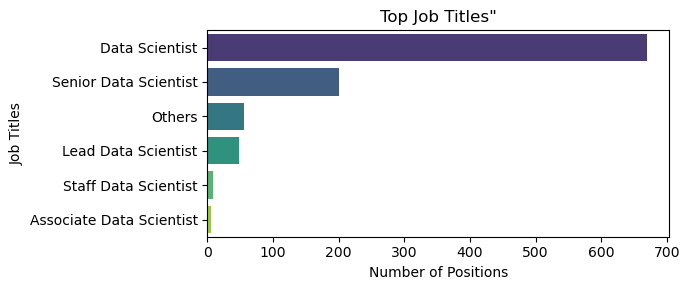

In [40]:
# Generate the plot
plt.figure(figsize=(7, 3))
sns.barplot(
    x=ideal_job_titles.Fixed_Title.value_counts(), y=ideal_job_titles.Fixed_Title.value_counts().index, palette='viridis', 
    hue=ideal_job_titles.Fixed_Title.value_counts().index, dodge=False, legend=False
)

plt.title('Top Job Titles"')
plt.xlabel('Number of Positions')
plt.ylabel('Job Titles')
plt.tight_layout()
plt.show()

#### Visualization for Locations where the roles are offered (including remote)

In [41]:
final_location_counts

Location
Bengaluru             452
Hyderabad             193
Pune                  170
Chennai               161
Mumbai                138
Others                112
Gurugram               83
Hybrid                 65
Kolkata                60
New Delhi              55
Noida                  46
Remote                 19
Ahmedabad              18
Kochi                  13
Mumbai (All Areas)     13
Navi Mumbai            10
Coimbatore             10
Name: count, dtype: int64

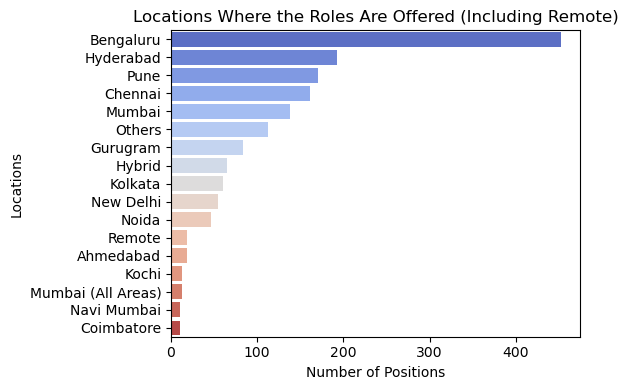

In [42]:
# Generate the plot
plt.figure(figsize=(6, 4))
sns.barplot(
    x=final_location_counts.values, y=final_location_counts.index, 
    hue=final_location_counts.index, palette='coolwarm', dodge=False, legend=False
)
plt.title('Locations Where the Roles Are Offered (Including Remote)')
plt.xlabel('Number of Positions')
plt.ylabel('Locations')
plt.tight_layout()
plt.show()

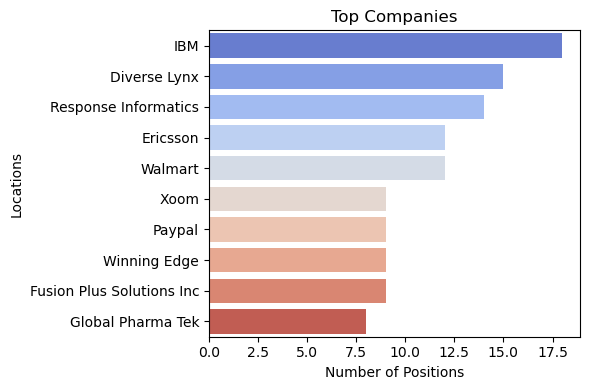

In [43]:
# Generate the plot
company_count = ideal_job_titles.Company.value_counts().head(10)
plt.figure(figsize=(6, 4))
sns.barplot(
    x=company_count.values, y=company_count.index, 
    hue=company_count.index, palette='coolwarm', dodge=False, legend=False
)
plt.title('Top Companies')
plt.xlabel('Number of Positions')
plt.ylabel('Locations')
plt.tight_layout()
plt.show()

#### A single job listing contains multiple locations, Hence the Actual Location records are more than the Job Listing

#### Visualization for Key Skills

In [44]:
top_skills = final_skill_counts[final_skill_counts.index != 'Others'].head(15)

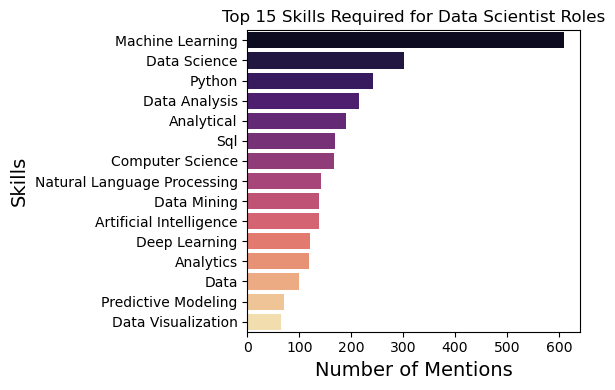

In [45]:
# Count the occurrences of each job type (Full-time or Part-time)
# Step 3: Visualization
plt.figure(figsize=(6, 4))
sns.barplot(
    x=top_skills.values, y=top_skills.index, palette='magma', 
    hue=top_skills.index, dodge=False, legend=False
)
plt.title('Top 15 Skills Required for Data Scientist Roles')
plt.xlabel('Number of Mentions', fontsize=14)
plt.ylabel('Skills', fontsize=14)
plt.tight_layout()
plt.show()

#### These are the top 15 Skills for the Ideal Job Title Data Scientist

##### Visualization for Salary Range (Top 10 for Ideal Job Role)

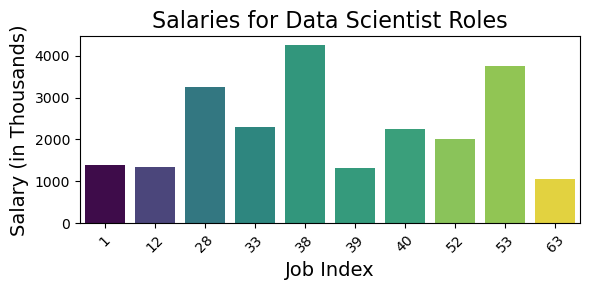

In [46]:
#Sort the data by Salary_in_Thousands
ideal_job_salary_sorted = ideal_job_salary.sort_values(by='Salary_in_Thousands')
#print(ideal_job_salary_sorted.info())

# Create the bar plot
plt.figure(figsize=(6, 3))
sns.barplot(x=ideal_job_salary_sorted.index, y='Salary_in_Thousands', data=ideal_job_salary_sorted, 
            hue=ideal_job_salary_sorted.index, legend=False, palette='viridis')

# Add titles and labels
plt.title('Salaries for Data Scientist Roles', fontsize=16)
plt.xlabel('Job Index', fontsize=14)
plt.ylabel('Salary (in Thousands)', fontsize=14)
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()
plt.show()

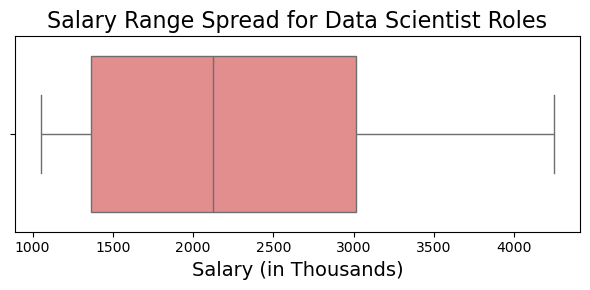

In [47]:
# Create the box plot
plt.figure(figsize=(6, 3))
sns.boxplot(x='Salary_in_Thousands', data=ideal_job_salary_sorted, color='lightcoral')

# Add titles and labels
plt.title('Salary Range Spread for Data Scientist Roles', fontsize=16)
plt.xlabel('Salary (in Thousands)', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

#### Average Salary is around 2100 thousand INR PA, with min from 100K to max upto 4000K. However there is not enough data available for Salary and most of the Jobs were listed without specifying any Salary Range.

In [48]:
ideal_job_titles.Salary_Range.value_counts().head(10)

Salary_Range
Not disclosed    903
20-35 Lacs PA     11
15-25 Lacs PA      6
Unpaid             5
10-20 Lacs PA      5
15-30 Lacs PA      3
16-30 Lacs PA      3
30-45 Lacs PA      3
20-30 Lacs PA      3
25-40 Lacs PA      3
Name: count, dtype: int64

In [49]:
# Example function to convert experience to a single numeric value in years
def convert_experience_to_years(experience):    
    # Experience is in 3-4+ years format. It's a string
    if isinstance(experience, str):
        # First remove all non numeric items like years, yrs, +
        experience = re.sub(r'(years|\+|yrs)', '', experience, flags=re.IGNORECASE).strip()
        # Handle ranges like 3-5 convert it to average range
        if '-' in experience:
            min_years, max_years = experience.split('-')
            return (float(min_years.strip()) + float(max_years.strip())) / 2
        
        # Handle 
        else:
            return float(experience.strip())
    else:
        # If experience is already a number or cannot be parsed, return as is or NaN
        return pd.to_numeric(experience, errors='coerce')

# Apply the conversion to the 'Experience' column
if 'Years_of_Experience' in ideal_job_salary_sorted.columns:
    ideal_job_salary_sorted.drop(columns='Years_of_Experience', inplace=True)
    
ideal_job_salary_sorted['Years_of_Experience'] = ideal_job_salary_sorted['Experience'].apply(convert_experience_to_years)


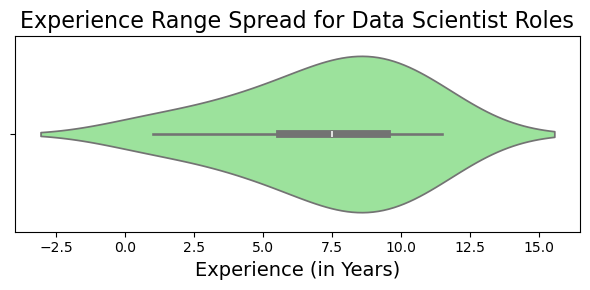

In [50]:
# Create the box plot
plt.figure(figsize=(6, 3))
sns.violinplot(x='Years_of_Experience', data=ideal_job_salary_sorted, color='lightgreen')

# Add titles and labels
plt.title('Experience Range Spread for Data Scientist Roles', fontsize=16)
plt.xlabel('Experience (in Years)', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

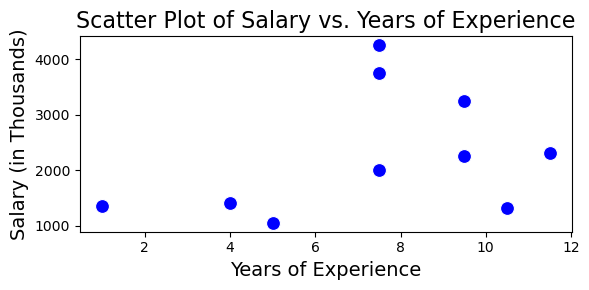

In [51]:
# Create the scatter plot
plt.figure(figsize=(6, 3))
sns.scatterplot(x='Years_of_Experience', y='Salary_in_Thousands', data=ideal_job_salary_sorted, color='blue', s=100)

# Add titles and labels
plt.title('Scatter Plot of Salary vs. Years of Experience', fontsize=16)
plt.xlabel('Years of Experience', fontsize=14)
plt.ylabel('Salary (in Thousands)', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

#### We didn't observed any clear linear relationship between salary and experience. This can't be depended as too few jobs were posted with Salary Range details.

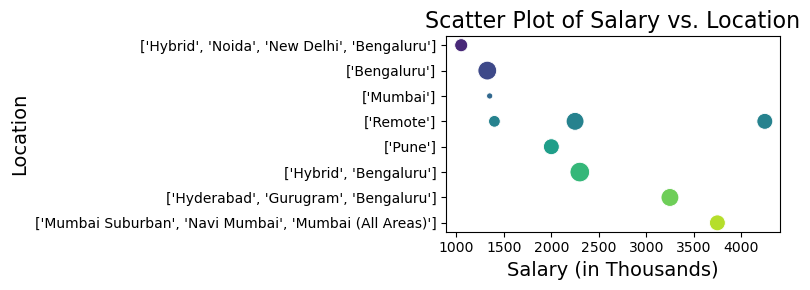

In [52]:
# Create the scatter plot for all locations, with Salary in Thousand
plt.figure(figsize=(8, 3))
sns.scatterplot(x='Salary_in_Thousands', y='Location', data=ideal_job_salary_sorted, hue='Location', 
                size='Years_of_Experience', palette='viridis', s=100, legend=False, sizes=(20, 200))

# Add titles and labels
plt.title('Scatter Plot of Salary vs. Location', fontsize=16)
plt.xlabel('Salary (in Thousands)', fontsize=14)
plt.ylabel('Location', fontsize=14)

# Show plot
plt.tight_layout()
plt.show()

#### There seems to be a negative linear relationship exists between Location, Experience and Salary, however too fewer observations are available for salary range, plus jobs are being posted with more than 1 locations for a single job listing. Hence it can't be deduced with only this data.

---
## C. Your ideal Job with required Skills
---

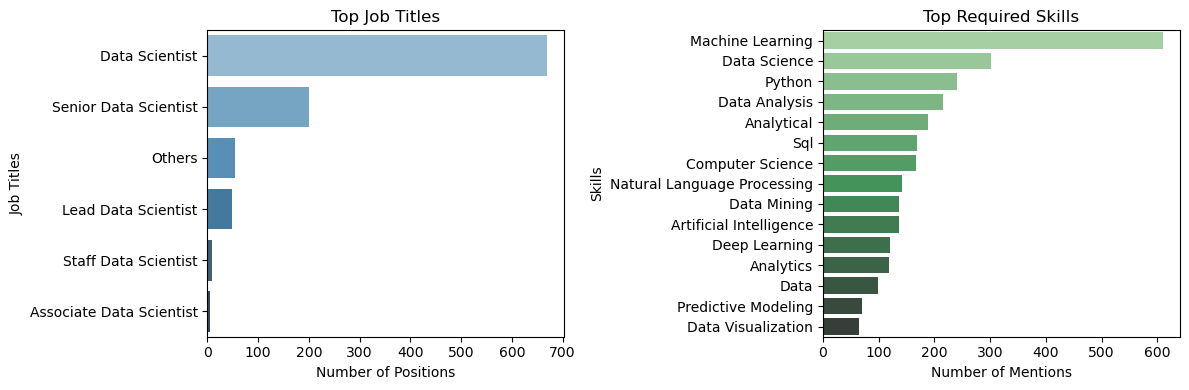

In [53]:
# Required Skills for the Ideal Jost (Data Scientist)

# Create a figure with 1 row and 2 columns for subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# First plot: Top Job Titles
sns.barplot(x=ideal_job_titles.Fixed_Title.value_counts(), y=ideal_job_titles.Fixed_Title.value_counts().index, 
            ax=axes[0], palette='Blues_d', hue=ideal_job_titles.Fixed_Title.value_counts().index, legend=False)
axes[0].set_title('Top Job Titles', fontsize=12)
axes[0].set_xlabel('Number of Positions', fontsize=10)
axes[0].set_ylabel('Job Titles', fontsize=10)

# Second plot: Top 15 Required Skills
sns.barplot(x=top_skills.values, y=top_skills.index, ax=axes[1], palette='Greens_d',
            hue=top_skills.index, legend=False)
axes[1].set_title('Top Required Skills', fontsize=12)
axes[1].set_xlabel('Number of Mentions', fontsize=10)
axes[1].set_ylabel('Skills', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()